## 1. Install

Create conda env `gai-ttt-svr` and install gai-ttt-svr package. After that, switch the kernel to `gai-ttt-svr` before proceeding further.


In [ ]:
%%bash
conda create -n gai-ttt-svr python=3.10.10 -y
eval "$(conda shell.bash hook)" && conda activate gai-ttt-svr
cd ../..
poetry install

## 2. Load test configuration

In [1]:
from gai.lib.server.singleton_host import SingletonHost
from gai.lib.common.utils import free_mem
from rich.console import Console
console=Console()

config = {
    "type": "ttt",
    "generator_name": "exllamav2-mistral7b",
    "engine": "gai.ttt.server.GaiExLlamaV2",
    "model_path": "models/exllamav2-mistral7b",
    "model_basename": "model",
    "max_seq_len": 8192,
    "prompt_format": "mistral",
    "hyperparameters": {
        "temperature": 0.85,
        "top_p": 0.8,
        "top_k": 50,
        "max_new_tokens": 1000,
    },
    "tool_choice": "auto",
    "max_retries": 5,
    "stop_conditions": ["<s>", "</s>", "user:","\n\n"],
    "no_flash_attn":True,
    "seed": None,
    "decode_special_tokens": False,
    "module_name": "gai.ttt.server.gai_exllamav2",
    "class_name": "GaiExLlamav2",
    "init_args": [],
    "init_kwargs": {}
}

## 3. Load Model Test

In [2]:
# before loading
free_mem()
try:
    with SingletonHost.GetInstanceFromConfig(config) as host:
        # The following initialization will take place each time a completion is created
        host.generator.load_generator()
        host.generator.initialize_job_state(messages=[
            {"role":"user","content":"hello world"},
            {"role":"assistant","content":""}
            ],stream=False)
        host.generator.load_job()

        # after loading
        free_mem()
except Exception as e:
    raise e
finally:
    # after disposal
    free_mem()
    

Free memory: 1.06 GB

## 3. Completion

### a) Test streaming

In [4]:
try:
    with SingletonHost.GetInstanceFromConfig(config, verbose=False) as host:
        response = host.create(
            messages=[{"role":"user","content":"Tell me a one sentence story"},
                      {"role":"assistant","content":""}],
            stream=True)
        for message in response:
            if message.choices[0].delta.content:
                print(message.choices[0].delta.content, end="", flush=True)
except Exception as e:
    raise e
finally:
    # after disposal
    free_mem()
    

 A young girl found a magic lamp and released a genie who granted her three wishes.

Free memory: 5.72 GB

### b) Test generation

In [5]:
try:
    with SingletonHost.GetInstanceFromConfig(config,verbose=False) as host:
        response = host.create(
            messages=[{"role":"user","content":"Tell me a one paragraph story"},
                      {"role":"assistant","content":""}],
            stream=False)
        print(response.choices[0].message.content)
except Exception as e:
    raise e
finally:
    # after disposal
    free_mem()
    

 Once upon a time, in a small village nestled between the mountains, lived a humble farmer named Tomas. Despite his simple life, Tomas was known for his kind heart and generous spirit. One day, a fierce storm swept through the valley, destroying Tomas's crops and leaving him with nothing to feed his family. Instead of giving up, Tomas rallied the villagers together, and they worked tirelessly to replant and rebuild. Their efforts paid off, and the village flourished once more. This tale serves as a reminder that even in the face of adversity, unity and resilience can lead to prosperity.


Free memory: 5.72 GB

### c) Test Tool Calling

In [6]:
try:
    with SingletonHost.GetInstanceFromConfig(config,verbose=False) as host:
        messages = [
            {"role":"user","content":"What is the current time in Singapore?"},
            {"role":"assistant","content":""}
        ]
        tool_choice="required"
        tools = [
            {
                "type": "function",
                "function": {
                    "name": "google",
                    "description": "The 'google' function is a powerful tool that allows the AI to gather external information from the internet using Google search. It can be invoked when the AI needs to answer a question or provide information that requires up-to-date, comprehensive, and diverse sources which are not inherently known by the AI. For instance, it can be used to find current date, current news, weather updates, latest sports scores, trending topics, specific facts, or even the current date and time. The usage of this tool should be considered when the user's query implies or explicitly requests recent or wide-ranging data, or when the AI's inherent knowledge base may not have the required or most current information. The 'search_query' parameter should be a concise and accurate representation of the information needed.",
                    "parameters": {
                        "type": "object",
                        "properties": {
                            "search_query": {
                                "type": "string",
                                "description": "The search query to search google with. For example, to find the current date or time, use 'current date' or 'current time' respectively."
                            }
                        },
                        "required": ["search_query"]
                    }
                }
            }
        ]
        response = host.create(
            messages=messages,
            tools=tools,
            tool_choice=tool_choice,
            stream=False)
        print(response)
except Exception as e:
    raise e
finally:
    # after disposal
    free_mem()


ChatCompletion(id='chatcmpl-66dae288-b333-4287-a0ea-9634d8ec79be', choices=[Choice(finish_reason='tool_calls', index=0, logprobs=None, message=ChatCompletionMessage(content=None, refusal=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_fab3fcb1-cf25-4568-a507-f949eeeb294a', function=Function(arguments='{"search_query": "current time Singapore"}', name='google'), type='function')]))], created=1723390749, model='exllamav2-mistral7b', object='chat.completion', service_tier=None, system_fingerprint=None, usage=CompletionUsage(completion_tokens=21, prompt_tokens=336, total_tokens=357))


Free memory: 5.71 GB

## 4. API Service

Open Visual Code:

    a) CTRL + SHIFT + P
    b) Select "Python: Select Interpreter" > "gai-ttt-svr"

    c) Click "Debug" on Activity Bar.
    d) Choose "Python Debugger: gai-ttt-server" from the dropdown.
    e) Click on F5 to start the server.

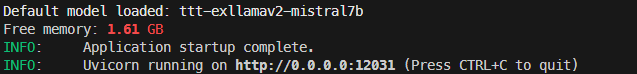

### a) Test Generating

In [1]:
%%bash
curl -X POST \
    http://localhost:12031/gen/v1/chat/completions \
    -H 'Content-Type: application/json' \
    -s \
    -N \
    -d "{\"model\":\"exllamav2-mistral7b\", \
        \"messages\": [ \
            {\"role\": \"user\",\"content\": \"Tell me a story.\"}, \
            {\"role\": \"assistant\",\"content\": \"\"} \
        ],\
        \"tool_choice\": \"none\"}"

{"id":"chatcmpl-97caf423-01ff-4644-9877-cdc7ebad9ab1","choices":[{"finish_reason":"stop","index":0,"logprobs":null,"message":{"content":" Once upon a time, in a land far, far away, there was a small village nestled between rolling hills and a sparkling river. The villagers lived simple lives, farming the land and caring for their animals. However, the village was plagued by a terrible beast that lurked in the nearby forest. This beast would often sneak into the village at night, causing terror and destruction wherever it went","refusal":null,"role":"assistant","function_call":null,"tool_calls":null}}],"created":1723475482,"model":"exllamav2-mistral7b","object":"chat.completion","service_tier":null,"system_fingerprint":null,"usage":{"completion_tokens":87,"prompt_tokens":14,"total_tokens":101}}

### b) Test Streaming

In [2]:
%%bash
curl -X POST \
    http://localhost:12031/gen/v1/chat/completions \
    -H 'Content-Type: application/json' \
    -s \
    -N \
    -d "{\"model\":\"exllamav2-mistral7b\", \
        \"messages\": [ \
            {\"role\": \"user\",\"content\": \"Tell me a story.\"}, \
            {\"role\": \"assistant\",\"content\": \"\"} \
        ],\
        \"stream\":true}"


{"id": "chatcmpl-1d369a6b-7f52-4295-a52e-0ceea138f947", "choices": [{"delta": {"content": "", "function_call": null, "refusal": null, "role": "assistant", "tool_calls": null}, "finish_reason": null, "index": 0, "logprobs": null}], "created": 1723475486, "model": "exllamav2-mistral7b", "object": "chat.completion.chunk", "service_tier": null, "system_fingerprint": null, "usage": null}
{"id": "chatcmpl-dd49dc88-4fa7-4550-a4b2-c3b781ddf0b1", "choices": [{"delta": {"content": " Once", "function_call": null, "refusal": null, "role": null, "tool_calls": null}, "finish_reason": null, "index": 0, "logprobs": null}], "created": 1723475486, "model": "exllamav2-mistral7b", "object": "chat.completion.chunk", "service_tier": null, "system_fingerprint": null, "usage": null}
{"id": "chatcmpl-5293de86-bb6f-435f-b27b-fb245eb3ca7b", "choices": [{"delta": {"content": " upon", "function_call": null, "refusal": null, "role": null, "tool_calls": null}, "finish_reason": null, "index": 0, "logprobs": null}], "

### c) Test Tool Calling

In [3]:
%%bash
curl -X POST \
    http://localhost:12031/gen/v1/chat/completions \
    -H 'Content-Type: application/json' \
    -s \
    -N \
    -d "{\"model\":\"exllamav2-mistral7b\", \
        \"messages\": [ \
            {\"role\": \"user\",\"content\": \"What is the current time in Singapore\"}, \
            {\"role\": \"assistant\",\"content\": \"\"} \
        ],\
        \"tools\": [\
            {\
                \"type\": \"function\",\
                \"function\": {\
                    \"name\": \"google\",\
                    \"description\": \"The 'google' function is a powerful tool that allows the AI to gather external information from the internet using Google search. It can be invoked when the AI needs to answer a question or provide information that requires up-to-date, comprehensive, and diverse sources which are not inherently known by the AI. For instance, it can be used to find current date, current news, weather updates, latest sports scores, trending topics, specific facts, or even the current date and time. The usage of this tool should be considered when the user's query implies or explicitly requests recent or wide-ranging data, or when the AI's inherent knowledge base may not have the required or most current information. The 'search_query' parameter should be a concise and accurate representation of the information needed.\",\
                    \"parameters\": {\
                        \"type\": \"object\",\
                        \"properties\": {\
                            \"search_query\": {\
                                \"type\": \"string\",\
                                \"description\": \"The search query to search google with. For example, to find the current date or time, use 'current date' or 'current time' respectively.\"\
                            }\
                        },\
                        \"required\": [\"search_query\"]\
                    }\
                }\
            }\
        ],\
        \"tool_choice\": \"required\"}"

{"id":"chatcmpl-7a4a7ef9-dc8f-4c8a-986d-21d7d0387762","choices":[{"finish_reason":"tool_calls","index":0,"logprobs":null,"message":{"content":null,"refusal":null,"role":"assistant","function_call":null,"tool_calls":[{"id":"call_e76edb4e-30f4-4d5b-ac34-0a6d4dd26247","function":{"arguments":"{\"search_query\": \"current time Singapore\"}","name":"google"},"type":"function"}]}}],"created":1723475493,"model":"exllamav2-mistral7b","object":"chat.completion","service_tier":null,"system_fingerprint":null,"usage":{"completion_tokens":21,"prompt_tokens":335,"total_tokens":356}}

### d) Test Response Model

In [10]:
%%bash
curl -X POST \
    http://localhost:12031/gen/v1/chat/completions \
    -H 'Content-Type: application/json' \
    -s \
    -N \
    -d "{\"model\":\"exllamav2-mistral7b\", \
        \"messages\": [ \
            {\"role\": \"user\",\"content\": \"Foundation is a science fiction novel by American writer \
            Isaac Asimov. It is the first published in his Foundation Trilogy (later \
            expanded into the Foundation series). Foundation is a cycle of five \
            interrelated short stories, first published as a single book by Gnome Press \
            in 1951. Collectively they tell the early story of the Foundation, \
            an institute founded by psychohistorian Hari Seldon to preserve the best \
            of galactic civilization after the collapse of the Galactic Empire.\"}, \
            {\"role\": \"assistant\",\"content\": \"\"} \
        ],\
        \"response_model\": {\"properties\": \
            {\"title\": \
                {\"title\": \"Title\", \"type\": \"string\"}, \
                    \"summary\": {\"title\": \"Summary\", \"type\": \"string\"}, \
                    \"author\": {\"title\": \"Author\", \
                    \"type\": \"string\"\
                }, \
                \"published_year\": {\
                    \"title\": \"Published Year\", \
                    \"type\": \"integer\"}}, \
                \"required\": [\
                    \"title\", \
                    \"summary\", \
                    \"author\", \
                    \"published_year\"\
                ], \
                \"title\": \"Book\", \
                \"type\": \"object\"\
            },\
        \"tool_choice\": \"none\"}"

{"id":"chatcmpl-2222fe80-7313-4fe0-8746-5a10869dc179","choices":[{"finish_reason":"stop","index":0,"logprobs":null,"message":{"content":" {\n  \"title\": \"Foundation\",\n  \"summary\": \"Foundation is a science fiction novel by Isaac Asimov, the first published in his Foundation Trilogy. It is a cycle of five interrelated short stories that tell the early story of the Foundation, an institute founded by psychohistorian Hari Seldon to preserve the best of galactic civilization after the collapse of the Galactic Empire.\",\n  \"author\": \"Isaac Asimov\",\n  \"published_year\": 1951\n}","refusal":null,"role":"assistant","function_call":null,"tool_calls":null}}],"created":1723391099,"model":"exllamav2-mistral7b","object":"chat.completion","service_tier":null,"system_fingerprint":null,"usage":{"completion_tokens":116,"prompt_tokens":253,"total_tokens":369}}

### e) Shut down the API Service

## 5. Docker

a) Open Visual Code

b) Press `CTRL + SHIFT + P` and "Tasks: Run Task" > "[gai-ttt] run"

c) Check the docker logs to confirm the model is ready.

d) Repeat all the tests above.